# RFM Clustering of Customers using K-Means
## Description of data set

- **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.
- **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
- **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal. The name of the country where a customer resides.

# 1) Data Understanding

In [1]:
import pandas as pd    
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);
pd.set_option('display.float_format', lambda x: '%.0f' % x)
import matplotlib.pyplot as plt

#Data set reading process was performed.
df_2010_2011 = pd.read_excel("../input/uci-online-retail-ii-data-set/online_retail_II.xlsx", sheet_name = "Year 2010-2011")
df = df_2010_2011.copy()

# DATA PREPROCESSING
# We extract the returned transactions from the data.
returned = df[df["Invoice"].str.contains("C",na=False)].index
df = df.drop(returned, axis = 0)

#How much money has been earned per invoice? (It is necessary to create a new variable by multiplying two variables)
df["TotalPrice"] = df["Quantity"]*df["Price"]
# Missing observations were deleted.
df.dropna(inplace = True)


#RFM METRIC ACCOUNT

#RECENCY METRIC
import datetime as dt
today_date = dt.datetime(2011,12,9)
df["Customer ID"] = df["Customer ID"].astype(int)
temp_df = (today_date - df.groupby("Customer ID").agg({"InvoiceDate":"max"}))
temp_df.rename(columns={"InvoiceDate": "Recency"}, inplace = True)
recency_df = temp_df["Recency"].apply(lambda x: x.days)

# FREQUENCY METRIC
temp_df = df.groupby(["Customer ID","Invoice"]).agg({"Invoice":"count"})
freq_df = temp_df.groupby("Customer ID").agg({"Invoice":"count"})
freq_df.rename(columns={"Invoice": "Frequency"}, inplace = True)

# MONETARY METRIC
monetary_df = df.groupby("Customer ID").agg({"TotalPrice":"sum"})
monetary_df.rename(columns = {"TotalPrice": "Monetary"}, inplace = True)
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
df = rfm
df["RecencyScore"] = pd.qcut(df['Recency'], 5, labels = [5, 4, 3, 2, 1])
df["FrequencyScore"] = pd.qcut(df['Frequency'].rank(method = "first"), 5, labels = [1,2,3,4,5])
df["MonetaryScore"] = pd.qcut(df['Monetary'], 5, labels = [1,2,3,4,5])
df["RFM_SCORE"] = df['RecencyScore'].astype(str) + df['FrequencyScore'].astype(str) + df['MonetaryScore'].astype(str)
seg_map = {
        r'[1-2][1-2]': 'Hibernating',
        r'[1-2][3-4]': 'At Risk',
        r'[1-2]5': 'Can\'t Loose',
        r'3[1-2]': 'About to Sleep',
        r'33': 'Need Attention',
        r'[3-4][4-5]': 'Loyal Customers',
        r'41': 'Promising',
        r'51': 'New Customers',
        r'[4-5][2-3]': 'Potential Loyalists',
        r'5[4-5]': 'Champions'
}

df['Segment'] = df['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
df['Segment'] = df['Segment'].replace(seg_map, regex=True)
df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346,324,1,77184,1,1,5,115,Hibernating
12347,1,7,4310,5,5,5,555,Champions
12348,74,4,1797,2,4,4,244,At Risk
12349,17,1,1758,4,1,4,414,Promising
12350,309,1,334,1,1,2,112,Hibernating


In [2]:
rfm = df.loc[:,"Recency":"Monetary"]

In [3]:
df.groupby("Customer ID").agg({"Segment": "sum"}).head()

,Segment
Customer ID,
12346,Hibernating
12347,Champions
12348,At Risk
12349,Promising
12350,Hibernating


# 2) Clustering with the K-Means Algorithm

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler((0,1))
df = sc.fit_transform(rfm)
kmeans = KMeans(n_clusters = 10)
k_fit = kmeans.fit(df)
k_fit.labels_

array([7, 9, 4, ..., 9, 9, 0], dtype=int32)

# 3) Determining the Optimum Number of Clusters

Text(0.5, 1.0, 'Elbow method for Optimum number of clusters')

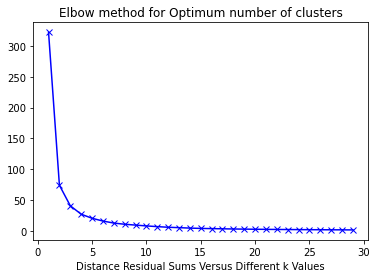

In [5]:
kmeans = KMeans(n_clusters = 10)
k_fit = kmeans.fit(df)
ssd = []

K = range(1,30)

for k in K:
    kmeans = KMeans(n_clusters = k).fit(df)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums Versus Different k Values")
plt.title("Elbow method for Optimum number of clusters")

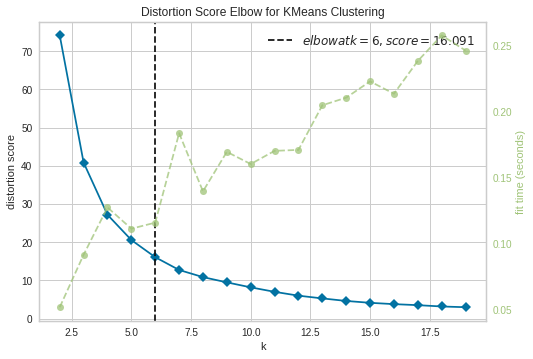

In [6]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,20))
visu.fit(df)
visu.poof();

In [7]:
kmeans = KMeans(n_clusters = 6).fit(df)
kumeler = kmeans.labels_
pd.DataFrame({"Customer ID": rfm.index, "Kumeler": kumeler})
rfm["cluster_no"] = kumeler
rfm["cluster_no"] = rfm["cluster_no"] + 1

In [8]:
rfm.groupby("cluster_no").agg({"cluster_no":"count"})

,cluster_no
cluster_no,
1,518
2,2030
3,298
4,1026
5,443
6,24


In [9]:
rfm.head()

,Recency,Frequency,Monetary,cluster_no
Customer ID,,,,
12346,324,1,77184,3
12347,1,7,4310,2
12348,74,4,1797,4
12349,17,1,1758,2
12350,309,1,334,3
